# ChangeOutfit with Segment Anything Model (SAM)

In [21]:
# ==============================================
# 1)  Environment setup  (first-time only)
# ==============================================
# NOTE:  For Intel MacBook Pro we install CPU-only PyTorch.
# If you have a GPU-accelerated external eGPU (rare on macOS) adjust the command.

!pip install --upgrade --quiet torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
!pip install --upgrade --quiet opencv-python matplotlib
!pip install --upgrade --quiet git+https://github.com/facebookresearch/segment-anything.git

In [22]:
import torch, cv2, numpy as np, matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import ssl, certifi, requests, tqdm
from rembg import remove           # AI-based background removal
from PIL      import Image
import pathlib

In [23]:
# ==============================================
# 2)  Imports & device selection
# ==============================================
DEVICE = "cpu"          # Intel MacBook → CPU
CHECKPOINT_NAME = "sam_vit_h_4b8939.pth"
CHECKPOINT_URL  = f"https://dl.fbaipublicfiles.com/segment_anything/{CHECKPOINT_NAME}"


In [24]:
# ==============================================
# 3)  Download the checkpoint (one-time)  ✅ FIXED
# ==============================================

weights = pathlib.Path("models") / CHECKPOINT_NAME
weights.parent.mkdir(exist_ok=True)

if not weights.exists():
    print("Downloading SAM checkpoint with verified SSL…")
    # requests automatically uses certifi’s CA bundle
    with requests.get(CHECKPOINT_URL, stream=True, timeout=60) as r:
        r.raise_for_status()
        total = int(r.headers.get("Content-Length", 0))
        with open(weights, "wb") as f, tqdm.tqdm(
            total=total, unit="B", unit_scale=True, desc=CHECKPOINT_NAME
        ) as pbar:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
                pbar.update(len(chunk))
else:
    print("Checkpoint already present:", weights)


Checkpoint already present: models/sam_vit_h_4b8939.pth


(-0.5, 649.5, 620.5, -0.5)

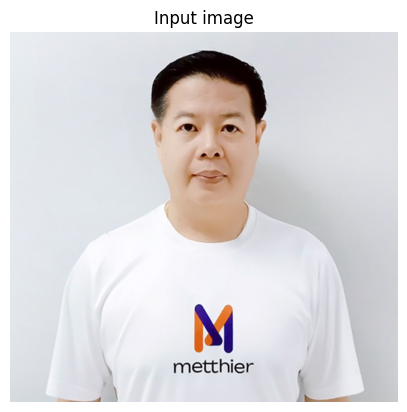

In [25]:
# ==============================================
# 4)  Load the image
# ==============================================
IMG_PATH = "1.1 Support.jpg"   # adjust if needed
bgr   = cv2.imread(IMG_PATH)
if bgr is None:
    raise FileNotFoundError(f"Could not read {IMG_PATH}")
rgb   = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(5,5)); plt.imshow(rgb); plt.title("Input image"); plt.axis("off")


In [26]:
# ==============================================
# 5)  Load SAM model
# ==============================================
sam = sam_model_registry["vit_h"](checkpoint=str(weights))
sam.to(device=DEVICE)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

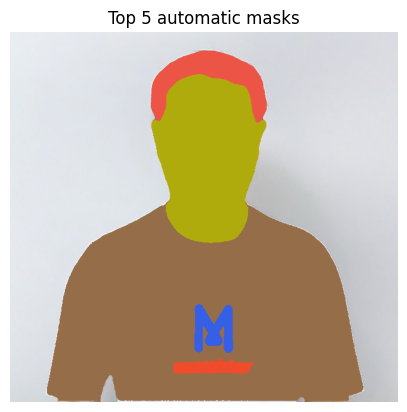

In [27]:
# ==============================================
# 6)  Automatic Mask Generation
#      – good for exploratory inspection
# ==============================================
mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side       = 32,
    min_mask_region_area  = 512,     # filter out tiny blobs
)
auto_masks = mask_generator.generate(rgb)

def show_masks(src, masks, n_show=5):
    overlay = src.copy()
    for i, m in enumerate(masks[:n_show]):
        color = np.random.randint(0, 256, (1, 3), dtype=np.uint8)
        overlay[m["segmentation"]] = color
    plt.figure(figsize=(5,5))
    plt.title(f"Top {n_show} automatic masks")
    plt.imshow(overlay); plt.axis("off")
    plt.show()

show_masks(rgb, auto_masks, n_show=5)

✔️  Saved → image_without_shirt.png


Text(0.5, 1.0, 'เสื้อถูกลบออกแล้ว')

/Users/nonthpawit.soo/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/nonthpawit.soo/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 3626 (\N{THAI CHARACTER SO SUA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/nonthpawit.soo/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 3639 (\N{THAI CHARACTER SARA UEE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/nonthpawit.soo/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 3657 (\N{THAI CHARACTER MAI THO}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/Users/nonthpawit.soo/Library/Python/3.10/lib/python/site-packages/IPython/core/events.py:82: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from font(s) DejaVu Sans.
  

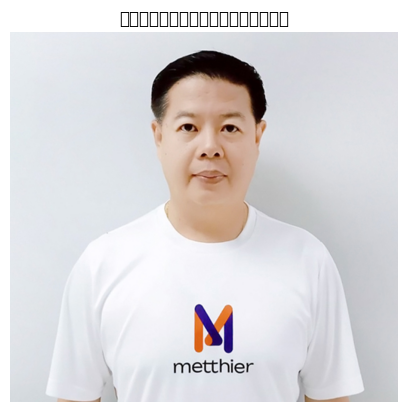

In [28]:
# ==============================================
# 7)  เลือก mask เฉพาะ 'เสื้อ' (Box-prompted)
# ==============================================
from segment_anything import SamPredictor
predictor = SamPredictor(sam)
predictor.set_image(rgb)

# ---- กรอบคร่าว ๆ รอบเสื้อ (x0,y0,x1,y1) ----
#    ปรับตามภาพของคุณ
bbox_shirt = np.array([60, 240, 630, 650])   # <— แก้ค่าตามต้องการ

# ถ้าอยาก interactive:  bbox_shirt = cv2.selectROI("select shirt", bgr, False, False)

# predict หลาย mask แล้วเลือกอันที่ใหญ่ที่สุด (น่าจะเป็นเสื้อ)
masks, scores, _ = predictor.predict(
    box=bbox_shirt[None, :],
    multimask_output=True
)
# เลือก mask ที่มี area มากที่สุด ซึ่งมักจะเป็นเสื้อ
areas = masks.reshape(masks.shape[0], -1).sum(axis=1)
shirt_mask = masks[np.argmax(areas)]

# ==============================================
# 8)  สร้างภาพใหม่ที่ ‘ลบเสื้อออก’ (alpha = 0 ตรงเสื้อ)
# ==============================================
# alpha = 255 ทุก pixel  ยกเว้นเสื้อ = 0
alpha = np.where(shirt_mask, 0, 255).astype(np.uint8)
rgba  = np.dstack([rgb, alpha])

out_path = "image_without_shirt.png"
cv2.imwrite(out_path, cv2.cvtColor(rgba, cv2.COLOR_RGBA2BGRA))
print(f"✔️  Saved → {out_path}")

# แสดงผลดูเร็ว ๆ
plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(rgba, cv2.COLOR_RGBA2RGB))
plt.axis("off"); plt.title("เสื้อถูกลบออกแล้ว")
